## results for fibroblast cell type

Also making data loading and plotting functions 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.decomposition import PCA
import os
import tensorqtl
from tensorqtl import pgen, cis, trans, post, genotypeio

from upsetplot import from_memberships,  plot
from tqdm.auto import tqdm  # for notebooks

import ast

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

### control eqtl analysis comparison to pcqtl analysis



In [2]:
#tissue_id = 'Whole_Blood'
chr_id = '21'
pc_id = 1
tissue_id = 'Cells_Cultured_fibroblasts'
prefix = '/home/klawren/oak/pcqtls'

df = pd.read_csv(f"{prefix}/data/references/selected_tissue_ids.csv", header=0)
tissue_ids = list(df['Tissue'])


In [3]:
pc1_susie_df = pd.read_csv(f'{prefix}/output/pcqtl/{tissue_id}/{tissue_id}.v8.pc_1.susie.txt', sep='\t', index_col=0)
pc2_susie_df = pd.read_csv(f'{prefix}/output/pcqtl/{tissue_id}/{tissue_id}.v8.pc_2.susie.txt', sep='\t', index_col=0)
e_susie_df = pd.read_csv(f'{prefix}/output/control_eqtl/{tissue_id}/{tissue_id}.v8.cluster_genes.susie.txt', sep='\t', index_col=0)

overlap_df = pd.read_csv(f'{prefix}/output/overlap/{tissue_id}.v8.overlap.txt', sep='\t')

In [8]:
def generate_overlap_dict(susie_df):
    overlap_dict = susie_df.groupby('variant_id')['cs_id'].apply(set).to_dict()
    return overlap_dict

def get_overlap_ids_optimized(row, overlap_dict):
    overlap_ids = set()
    for variant_id in row.variant_list:
        if variant_id in overlap_dict:
            overlap_ids.update(overlap_dict[variant_id])
    return list(overlap_ids)

In [9]:
# get the cs's with overlapping variants (even 1 overlapping variant qualifies)

e_overlap_dict = generate_overlap_dict(e_susie_df)
e_overlap_df['e_overlap'] = e_overlap_df.apply(get_overlap_ids_optimized, axis=1, args=(e_overlap_dict,))

pc1_overlap_dict = generate_overlap_dict(pc1_susie_df)
e_overlap_df['pc1_overlap'] = e_overlap_df.apply(get_overlap_ids_optimized, axis=1, args=(pc1_overlap_dict,))

pc2_overlap_dict = generate_overlap_dict(pc2_susie_df)
e_overlap_df['pc2_overlap'] = e_overlap_df.apply(get_overlap_ids_optimized, axis=1, args=(pc2_overlap_dict,))

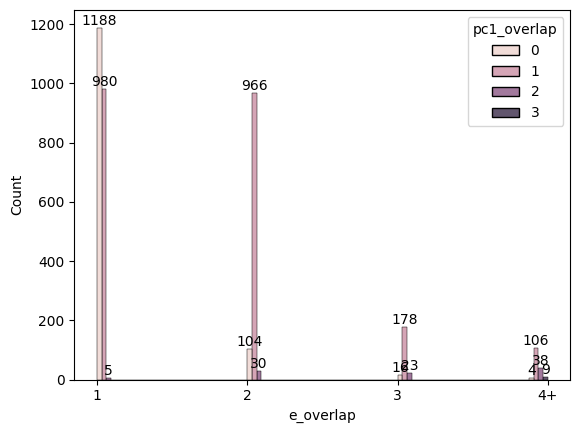

In [10]:
# this plot is a bit wierd in that it double counts a credible set if it shows up for multiple egenes
y=sns.histplot(x=np.clip(e_overlap_df['e_overlap'].apply(len), 0,4), hue=e_overlap_df['pc1_overlap'].apply(len), multiple='dodge')
for i in range(len(y.containers)):
    labels = [str(v) if v else '' for v in y.containers[i].datavalues]
    y.bar_label(y.containers[i], labels=labels)
y.set_xticks([1,2,3, 4])
y.set_xticklabels(['1', '2', '3', '4+'])
plt.show()

In [ ]:
def num_egenes(gene_id_list, match_df):
    # the relevant genes
    return e_susie_df[e_susie_df['phenotype_id'].isin(gene_id_list)]['cs_id'].unique()

In [ ]:
# load results from nominal ps
def var_pos(df):
    return df['variant_id'].str.split('_').str[1].astype(int)

# pc results
def load_pc_pairs(path):
    pairs_df = pd.read_parquet(path)
    pairs_df['variant_pos'] = var_pos(pairs_df)
    pairs_df['cluster_id'] = pairs_df['phenotype_id'].str[:-4]
    pairs_df['cluster_size'] = pairs_df['phenotype_id'].str.split('_').str.len() - 1
    pairs_df['num_qtl'] = pairs_df.groupby('variant_id')['phenotype_id'].transform('count')
    return pairs_df

def load_pc_indep(path):
    indep_df = pd.read_csv(path, sep='\t')
    indep_df['variant_pos'] = var_pos(indep_df)
    indep_df['cluster_id'] = indep_df['phenotype_id'].str[:-4]
    return indep_df

pc_pairs_df = load_pc_pairs(f'../../output/pcqtl/{tissue_id}/{tissue_id}.v8.pc_1.cis_qtl_pairs.chr{chr_id}.parquet')
pc_indep_df = load_pc_indep(f'{pc_out_prefix}/pcqtl/{tissue_id}/{tissue_id}.v8.pc_1.cis_independent_qtl.txt.gz')
#pc2_indep_df = load_pc_indep(f'{pc_out_prefix}/pcqtl/{tissue_id}/{tissue_id}.v8.pc_2.cis_independent_qtl.txt.gz')


pc_susie_df = pd.read_csv(f'{pc_out_prefix}/pcqtl/{tissue_id}/{tissue_id}.v8.pc_1.susie.txt', sep='\t')
pc2_susie_df = pd.read_csv(f'{pc_out_prefix}/pcqtl/{tissue_id}/{tissue_id}.v8.pc_2.susie.txt', sep='\t')


# e results
e_pairs_df = pd.read_parquet(f'{e_out_prefix}/{tissue_id}/{tissue_id}.v8.cluster_genes.cis_qtl_pairs.chr{chr_id}.parquet')
e_pairs_df['variant_pos'] = var_pos(e_pairs_df)
e_pairs_df['num_qtl'] = e_pairs_df.groupby('variant_id')['phenotype_id'].transform('count')
e_indep_df = pd.read_csv(f'{e_out_prefix}/{tissue_id}/{tissue_id}.v8.cluster_genes.cis_independent_qtl.txt.gz', sep='\t')
e_indep_df['variant_pos'] = var_pos(e_indep_df)
e_susie_df = pd.read_csv(f'{e_out_prefix}/{tissue_id}/{tissue_id}.v8.cluster_genes.susie.txt', sep='\t')


# load phenotypes and covariates
pc_path = f'{pc_out_prefix}/pcs/{tissue_id}/{tissue_id}.pc_1.residualized.chr{chr_id}.bed'
pc_phenotype_df, pc_phenotype_pos_df = tensorqtl.read_phenotype_bed(pc_path)
covariates_file = f'/home/klawren/oak/coexp_eqtl/tami_eqtl_proejct/data/{tissue_id}.v8.covariates.txt'
covariates_df = pd.read_csv(covariates_file, sep='\t', index_col=0).T
expression_bed = f'/home/klawren/oak/coexp_eqtl/tami_eqtl_proejct/data/{tissue_id}.v8.normalized_expression.bed'
e_phenotype_df, e_phenotype_pos_df = tensorqtl.read_phenotype_bed(expression_bed)

# load in cluster data
cluster_path = f'/home/klawren/oak/coexp_eqtl/tami_eqtl_proejct/output/1_correlations/{tissue_id}/clusters_chr_{chr_id}.csv'
cluster_df = pd.read_csv(cluster_path)
cluster_orig_columns = cluster_df.columns.values
cluster_df['cluster_id'] = cluster_df['Transcripts'].str.replace(',','_')


In [ ]:
def get_num_cs(susie_df):
    return len(susie_df.groupby(['phenotype_id','cs_id']))

In [ ]:
print('significant signals via permutation: \n\t* {} eqtl \n\t* {} primary pc \n\t* {} secondary pc'.format(len(e_indep_df['variant_id'].unique()), len(pc_indep_df['variant_id'].unique()), len(pc2_indep_df['variant_id'].unique())))

In [ ]:
print('independent signals via susie: \n\t* {} eqtl \n\t* {} primary pc \n\t* {} secondary pc'.format(get_num_cs(e_susie_df), get_num_cs(pc_susie_df), get_num_cs(pc2_susie_df)))

In [ ]:
# make a df with one row per credible set
pc_cs_df = pc_susie_df.groupby(['phenotype_id', 'cs_id']).agg({'pip':list, 'variant_id': list})
pc_cs_df = pc_cs_df.reset_index()
pc_cs_df['cluster_id'] = pc_cs_df['phenotype_id'].str[:-4]

pc2_cs_df = pc2_susie_df.groupby(['phenotype_id', 'cs_id']).agg({'pip':list, 'variant_id': list})
pc2_cs_df = pc2_cs_df.reset_index()
pc2_cs_df['cluster_id'] = pc2_cs_df['phenotype_id'].str[:-4]


e_cs_df = e_susie_df.groupby(['phenotype_id', 'cs_id']).agg({'pip':list, 'variant_id': list})
e_cs_df = e_cs_df.reset_index()

In [ ]:
# number of cluster credible sets where the a variant matches a variant in the credible set for 1+ 
# of the individual genes in the cluster 
def get_matching_ecs_pc(row):
    # just for egenes in the cluster
    gene_ids = row['cluster_id'].split('_')
    ecs_cluster = e_cs_df[e_cs_df['phenotype_id'].isin(gene_ids)]
    return get_matching_ecs(row, ecs_cluster)

def get_matching_ecs_e(row):
    # for any other gene
    return get_matching_ecs(row, e_cs_df)

def get_matching_ecs(row, ecs_cluster):
    matching_filter = [len(set(x)&set(row['variant_id']))>0 for x in ecs_cluster['variant_id']]
    if len(ecs_cluster[matching_filter])==0:
        return 0
    else:
        return len(ecs_cluster[matching_filter]['phenotype_id'].unique())

# check if in other pc df
def get_matching_pc2cs(row):
    pccs_cluster = pc2_cs_df[pc2_cs_df['cluster_id'] == row['cluster_id']]
    matching_filter = [len(set(x)&set(row['variant_id']))>0 for x in pccs_cluster['variant_id']]
    # false if no match, true otherwise
    if sum(matching_filter)>0:
        return 'pc_1_and_pc_2'
    else:
        return 'pc_1'
def get_matching_pc1cs(row):
    pccs_cluster = pc_cs_df[pc_cs_df['cluster_id'] == row['cluster_id']]
    matching_filter = [len(set(x)&set(row['variant_id']))>0 for x in pccs_cluster['variant_id']]
    # false if no match, true otherwise
    if sum(matching_filter)>0:
        return 'pc_1_and_pc_2'
    else:
        return 'pc_2'

In [ ]:
# turn into group - index is phenotype_id/csidx, columns for number of egenes and which pcs sig

pc_cs_df['n_match_egene'] = pc_cs_df.progress_apply(get_matching_ecs_pc, axis=1)
pc2_cs_df['n_match_egene'] = pc2_cs_df.progress_apply(get_matching_ecs_pc, axis=1)
e_cs_df['n_match_egene'] = e_cs_df.progress_apply(get_matching_ecs_e, axis=1)

pc_cs_df['match_pc'] = pc_cs_df.progress_apply(get_matching_pc2cs, axis=1)
pc2_cs_df['match_pc'] = pc2_cs_df.progress_apply(get_matching_pc1cs, axis=1)

In [ ]:
def in_pcs(row):
    idx1 = 0
    idx2 = 0
    for var_id in row['variant_id']:
        idx1 = idx1 + sum(pc_susie_df[pc_susie_df['variant_id'] == var_id]['phenotype_id'].str.contains(row.phenotype_id))
        idx2 = idx2 + sum(pc2_susie_df[pc2_susie_df['variant_id'] == var_id]['phenotype_id'].str.contains(row.phenotype_id))
    if idx1>0 and idx2>0:
        return 'pc_1_and_pc_2'
    elif idx1>0:
        return 'pc_1'
    elif idx2>0:
        return 'pc_2'
    else: 
        return 'no'

e_cs_df['match_pc'] = e_cs_df.progress_apply(in_pcs, axis=1)

In [ ]:
# add id
pc_cs_df['phen_cs_id'] = pc_cs_df['phenotype_id'].astype(str) + '_cs' + pc_cs_df['cs_id'].astype(str)
pc2_cs_df['phen_cs_id'] = pc2_cs_df['phenotype_id'].astype(str) + '_cs' + pc2_cs_df['cs_id'].astype(str)
e_cs_df['phen_cs_id'] = e_cs_df['phenotype_id'].astype(str) + '_cs' + e_cs_df['cs_id'].astype(str)

In [ ]:
# concat all the pc 2 not shared wtih pc1 to pc1
# concat all the egene not in pc

# cluster first approach (I think this makes more sense)

group = pd.concat([pc2_cs_df[pc2_cs_df['match_pc'] != 'pc_1_and_pc_2'][['n_match_egene', 'match_pc', 'phen_cs_id']], 
                      pc_cs_df[['n_match_egene', 'match_pc', 'phen_cs_id']], 
                      e_cs_df[e_cs_df['match_pc'] == 'no'][['n_match_egene', 'match_pc', 'phen_cs_id']]])

    

In [ ]:

# plot
group['n_match_egene_clip'] = np.clip(group['n_match_egene'], 0, 3)
y=sns.histplot(group, x='n_match_egene_clip', hue='match_pc', multiple='dodge', hue_order=['no', 'pc_1', 'pc_2', 'pc_1_and_pc_2'])
for i in range(len(y.containers)):
    labels = [str(v) if v else '' for v in y.containers[i].datavalues]
    y.bar_label(y.containers[i], labels=labels)
y.set_xticks([0,1,2,3])
y.set_xticklabels(['None', '1', '2', '3+'])
plt.title('Count of variants signifigant for egenes and via pc')
plt.xlabel('Number of significant egenes')
plt.ylabel('Number of variants')
plt.show()

In [ ]:
# upset without egene breakdowns
indep_upset = from_memberships(
    [['pc_1'],
     ['egene'],
     ['pc_1', 'egene'],
     ['pc_2'],
     ['pc_1', 'pc_2'],
     ['pc_2', 'egene'],
     ['pc_1', 'pc_2', 'egene']
     ],
     data=[sum((group['n_match_egene']==0)&(group['match_pc']=='pc_1')),
           sum((group['n_match_egene']!=0)&(group['match_pc']=='no')),  
           sum((group['n_match_egene']!=0)&(group['match_pc']=='pc_1')),
           sum((group['n_match_egene']==0)&(group['match_pc']=='pc_2')),
           sum((group['n_match_egene']==0)&(group['match_pc']=='pc_1_and_pc_2')),
           sum((group['n_match_egene']!=0)&(group['match_pc']=='pc_2')),
           sum((group['n_match_egene']!=0)&(group['match_pc']=='pc_1_and_pc_2')),
          ]
)


plot(indep_upset,show_counts=True)
plt.show()